In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/chest_xray/"

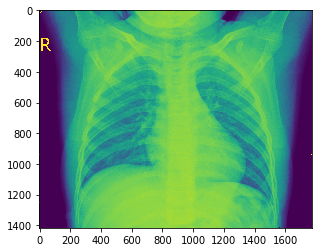

In [5]:
files = os.listdir(f'{PATH}valid/NORMAL')
img = plt.imread(f'{PATH}valid/NORMAL/{files[0]}')
plt.imshow(img)

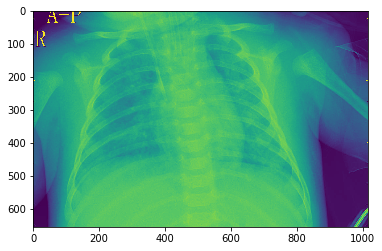

In [6]:
files_p = os.listdir(f'{PATH}valid/PNEUMONIA')
img_p = plt.imread(f'{PATH}valid/PNEUMONIA/{files_p[0]}')
plt.imshow(img_p)

In [7]:
arch = resnet34

In [11]:
def get_data(sz, bs):
    #Data Augmentation
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=2)
    #Create Data Object
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, test_name="test1", test_with_labels=True)
    return data

In [12]:
data = get_data(64,64)
learn = ConvLearner.pretrained(arch, data, ps=0.8, precompute=False)

In [13]:
print("train size: {}".format(data.trn_ds.n))
print("validation size: {}".format(data.val_ds.n))
print("test size: {}".format(data.test_ds.n))

train size: 5216
validation size: 16
test size: 624


In [14]:
lrf=learn.lr_find()

 88%|████████▊ | 72/82 [00:32<00:06,  1.66it/s, loss=3.09] 

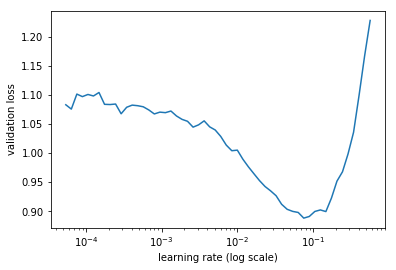

In [15]:
learn.sched.plot()

In [16]:
lr = 0.01
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.571147   0.455114   0.6875    
    1      0.499717   0.411346   0.75                      
    2      0.442726   0.450447   0.6875                    


[array([0.45045]), 0.6875]

In [17]:
learn.unfreeze()
lrs = np.array([lr/9,lr/3,lr])
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.371242   0.764563   0.625     
    1      0.317096   0.526287   0.75                      
    2      0.250885   0.448772   0.8125                    


[array([0.44877]), 0.8125]

In [18]:
data = get_data(128, 64)
learn.set_data(data)
learn.freeze()
learn.fit(0.01, 2 , cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.364554   0.565811   0.6875    
    1      0.377065   0.626342   0.625                     
    2      0.360294   0.639152   0.625                     


[array([0.63915]), 0.625]

In [19]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.238994   0.831723   0.625     
    1      0.215353   0.272848   0.875                     
    2      0.181019   0.280116   0.8125                    


[array([0.28012]), 0.8125]

In [20]:
data = get_data(256, 64)
learn.set_data(data)
learn.freeze()
learn.fit(0.01, 2, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.275316   0.557935   0.75      
    1      0.270887   0.58021    0.6875                    


[array([0.58021]), 0.6875]

In [21]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.220123   0.699618   0.625     
    1      0.213595   0.456735   0.75                      
    2      0.172207   0.563346   0.6875                    


[array([0.56335]), 0.6875]

In [22]:
#Apply Test Time Augmentation
log_probs, y = learn.TTA(is_test=True)

In [23]:
log_probs.shape

(5, 624, 2)

In [24]:
probs = np.mean(np.exp(log_probs), axis=0)

In [30]:
probs.shape
probs

array([[0.99027, 0.00973],
       [0.83703, 0.16297],
       [0.28195, 0.71805],
       ...,
       [0.00449, 0.99551],
       [0.01142, 0.98858],
       [0.78762, 0.21238]], dtype=float32)

In [26]:
#Baseline accuracy
print("Baseline accuracy: {}".format(y.mean()))

Baseline accuracy: 0.625


In [27]:
test_accuracy = accuracy_np(probs, y)
print("Test Set Accuracy: {}".format(test_accuracy))

Test Set Accuracy: 0.9086538461538461


[[180  54]
 [  3 387]]


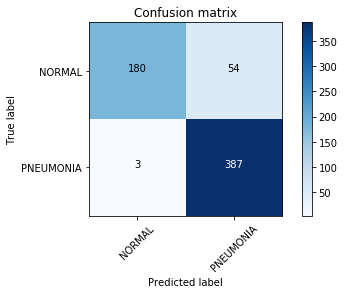

In [28]:
from sklearn.metrics import confusion_matrix
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)